# **Monte Carlo Simulation**

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import eigh

In [2]:
def ensure_pos_def(cov):
    # ensure covariance is positive definite: add tiny jitter along diagonal if needed
    # returns adjusted cov
    eps = 1e-8
    # eigh for symmetric matrices
    vals, vecs = eigh(cov)
    min_eig = vals.min()
    if min_eig < eps:
        jitter = (eps - min_eig)
        cov = cov + np.eye(cov.shape[0]) * jitter
    return cov

In [3]:
# Fit means & covariances on (hub, basis)
def fit_joint(df, hub_col):
    arr = df[[hub_col, 'basis']].dropna().values
    mu = arr.mean(axis=0)
    cov = np.cov(arr, rowvar=False)
    cov = ensure_pos_def(cov)
    return mu, cov

## **Monte Carlo Implementation** 

### **Formulae used:**
1. Basis = Busbar−Hub
2. Fixed Price (P75) = Percentile(busbar_sim, 25)

In [4]:
def plot(results_df):
    # ---- Quick plots ----
    plt.figure(figsize=(12, 5))
    plt.plot(results_df['Month'], results_df['Forward_Peak'], 'o-', label='Forward Peak')
    plt.plot(results_df['Month'], results_df['Sim_Peak_Mean'], 'x--', label='Simulated Peak Mean')
    plt.plot(results_df['Month'], results_df['Forward_Off'], 'o-', label='Forward Off-Peak')
    plt.plot(results_df['Month'], results_df['Sim_Off_Mean'], 'x--', label='Simulated Off-Peak Mean')
    plt.xticks(rotation=45)
    plt.ylabel('Price ($/MWh)')
    plt.title('Forward vs Monte Carlo Simulated Monthly Busbar Prices (Peak & Off-Peak)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # ---- Print a short table to console ----
    print(results_df[['Month','Forward_Peak','Sim_Peak_Mean','Forward_Off','Sim_Off_Mean']])

In [5]:
def montecarlo(data, fwd, gen):
    # Calculate basis for existing data
    data['basis'] = data['RT Busbar'] - data['RT Hub']
    
    # Split historical data by peak/off-peak
    peak_hist = data[data["P/OP"] == 1]
    off_hist = data[data["P/OP"] == 0]
    
    # Calculating mu and covariance for peak & off peak
    mu_off, cov_off = fit_joint(off_hist, 'RT Hub')
    mu_peak, cov_peak = fit_joint(peak_hist, 'RT Hub')

    # Normalize forward month names (keep as string for plotting)
    fwd['Month'] = fwd['Month'].astype(str)
    
    # Convert forward numeric columns
    fwd['Peak'] = fwd['Peak'].astype(float)
    fwd['Off Peak'] = fwd['Off Peak'].astype(float)
    
    # Normalize forward month names (keep as string for plotting)
    fwd['Month'] = fwd['Month'].astype(str)
    
    # Convert forward numeric columns
    fwd['Peak'] = fwd['Peak'].astype(float)
    fwd['Off Peak'] = fwd['Off Peak'].astype(float)
    
    # Print fitted params
    print("Fitted historical stats:")
    print("Off-peak mu (hub,basis):", mu_off, "samples:", len(off_hist))
    print("Off-peak cov:\n", cov_off)
    print("Peak mu (hub,basis):", mu_peak, "samples:", len(peak_hist))
    print("Peak cov:\n", cov_peak)

    
    # ---- Monte carlo ----
    rng = np.random.default_rng(42)
    N_SIMS = 30000  # number of Monte Carlo runs
    PERCENT = 25
    total_gen = gen_pred['final_pred'].sum()
    # mean_gen = gen_pred.groupby([gen_pred['Date'].dt.year, gen_pred['Date'].dt.month])['final_pred']
    # print(gen_pred.groupby([gen_pred['Date'].dt.year, gen_pred['Date'].dt.month]).head(10))
    
    results = []
    for idx, row in fwd.iterrows():
        month_label = row['Month']
        fwd_peak = float(row['Peak'])
        fwd_off = float(row['Off Peak'])
        # gen = mean_gen.
    
        # --- Off-peak simulation (simulating hub & basis) ---
        sims_off = rng.multivariate_normal(mean=mu_off, cov=cov_off, size=N_SIMS)
        hub_hist_off = sims_off[:, 0]
        basis_sim_off = sims_off[:, 1]
    
        # recenter hub to forward off-peak
        hub_off_shifted = hub_hist_off - hub_hist_off.mean() + fwd_off
        busbar_off_sim = hub_off_shifted + basis_sim_off                        # Busbar calculation
    
        # monthly stats
        off_mean = busbar_off_sim.mean()
        off_std = busbar_off_sim.std()
        off_var75 = np.percentile(busbar_off_sim, PERCENT)
        off_cvar75 = busbar_off_sim[busbar_off_sim <= off_var75].mean()
    
        # --- Peak simulation (simulating hub and basis)---
        sims_peak = rng.multivariate_normal(mean=mu_peak, cov=cov_peak, size=N_SIMS)
        hub_hist_peak = sims_peak[:, 0]
        basis_sim_peak = sims_peak[:, 1]
    
        hub_peak_shifted = hub_hist_peak - hub_hist_peak.mean() + fwd_peak
        busbar_peak_sim = hub_peak_shifted + basis_sim_peak                    # Busbar calculation
    
        peak_mean = busbar_peak_sim.mean()
        peak_std = busbar_peak_sim.std()
        peak_var75 = np.percentile(busbar_peak_sim, PERCENT)
        peak_cvar75 = busbar_peak_sim[busbar_peak_sim <= peak_var75].mean

        # Revenue
        
        results.append({
            'Month': month_label,
            'Forward_Peak': fwd_peak,
            'Sim_Peak_Mean': peak_mean,
            'Sim_Peak_STD': peak_std,
            'Peak_VaR_75': peak_var75,
            'Peak_CVaR_75': peak_cvar75,
            'Forward_Off': fwd_off,
            'Sim_Off_Mean': off_mean,
            'Sim_Off_STD': off_std,
            'Off_VaR_75': off_var75,
            'Off_CVaR_75': off_cvar75
        })
    
        # var75 = value risk - “The worst price I might see with 25% probability.”
        # CVar75 = conditional value at risk - “If the worst 25% happens, the average price I’ll see.”
    
    results_df = pd.DataFrame(results)
    results_df.head()
    plot(results_df)

    return results_df

C:\Users\Anup\AppData\Local\Temp\ipykernel_35408\3561214545.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv("../data/CAISO-Historical-Data.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
C:\Users\Anup\AppData\Local\Temp\ipykernel_35408\3561214545.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv("../data/CAISO-Historical-Data.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
C:\Users\Anup\AppData\Local\Temp\ipykernel_35408\3561214545.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version

Fitted historical stats:
Off-peak mu (hub,basis): [59.90337445  0.30258772] samples: 10944
Off-peak cov:
 [[2287.1008321   -16.22098191]
 [ -16.22098191   16.56662754]]
Peak mu (hub,basis): [64.06576102 -0.30955239] samples: 13114
Peak cov:
 [[4594.83468169   36.70292009]
 [  36.70292009   99.53298587]]


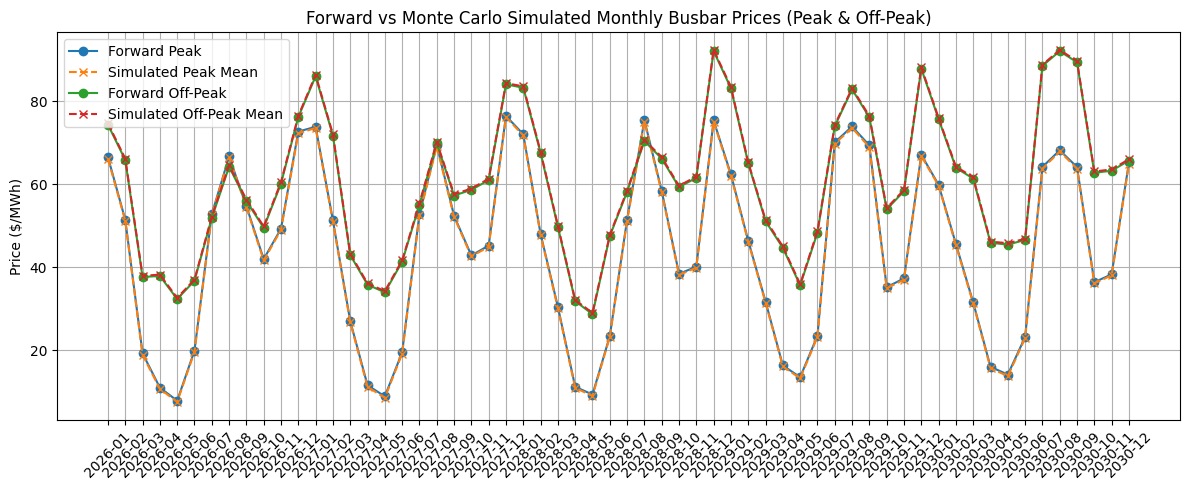

      Month  Forward_Peak  Sim_Peak_Mean  Forward_Off  Sim_Off_Mean
0   2026-01         66.49      66.098590        74.33     74.639946
1   2026-02         51.40      51.187706        65.81     66.126766
2   2026-03         19.21      18.864277        37.62     37.918249
3   2026-04         10.97      10.686745        37.87     38.189981
4   2026-05          7.81       7.521241        32.31     32.600597
5   2026-06         19.87      19.599775        36.72     36.990810
6   2026-07         52.73      52.449764        51.84     52.162264
7   2026-08         66.65      66.448033        64.20     64.487080
8   2026-09         54.69      54.386234        55.93     56.267763
9   2026-10         41.92      41.603372        49.48     49.797609
10  2026-11         49.26      48.993396        60.14     60.493878
11  2026-12         72.65      72.218412        76.16     76.447809
12  2027-01         73.81      73.523909        85.97     86.303938
13  2027-02         51.27      50.949151        

In [6]:
data = pd.read_csv("../data/CAISO-Historical-Data.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
fwd = pd.read_csv("../data/CAISO-Forward-Prices.csv")
gen_pred = pd.read_csv("../data/CAISO-Future-Predictions.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
fwd['Month'] = pd.to_datetime(fwd['Month'], format='%b-%y').dt.to_period('M').astype(str)
# gen_pred.head()
# fwd.head()
results_df = montecarlo(data, fwd, gen_pred)

In [7]:
# find the minimum Sim_Peak_Mean that exceeds the 75th percentile of Forward_Peak
threshold = results_df['Forward_Peak'].quantile(0.75)
mask = results_df['Sim_Peak_Mean'] > threshold

print(f"Forward_Peak 75th percentile: {threshold:.4f}")

if not mask.any():
    print("No Sim_Peak_Mean exceeds the 75th percentile of Forward_Peak.")
    min_beating_sim_peak_price = None
else:
    min_beating_sim_peak_price = results_df.loc[mask, 'Sim_Peak_Mean'].min()
    months = results_df[results_df['Sim_Peak_Mean'] == min_beating_sim_peak_price][['Month','Sim_Peak_Mean','Forward_Peak']]
    print(f"Minimum Sim_Peak_Mean that beats 75% of Forward_Peak: {min_beating_sim_peak_price:.4f}")
    print("Month(s) with that Sim_Peak_Mean:")
    print(months.to_string(index=False))


Forward_Peak 75th percentile: 64.4150
Minimum Sim_Peak_Mean that beats 75% of Forward_Peak: 64.8876
Month(s) with that Sim_Peak_Mean:
  Month  Sim_Peak_Mean  Forward_Peak
2030-12      64.887589         65.24


C:\Users\Anup\AppData\Local\Temp\ipykernel_35408\577938380.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv("../data/ERCOT-Historical-Data.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
C:\Users\Anup\AppData\Local\Temp\ipykernel_35408\577938380.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv("../data/ERCOT-Historical-Data.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
C:\Users\Anup\AppData\Local\Temp\ipykernel_35408\577938380.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A

Fitted historical stats:
Off-peak mu (hub,basis): [32.04532316 -6.54646031] samples: 13569
Off-peak cov:
 [[1991.28742516 -986.40681679]
 [-986.40681679 1229.89365117]]
Peak mu (hub,basis): [ 47.72490496 -15.27772834] samples: 11890
Peak cov:
 [[ 14646.02156494 -10969.66632098]
 [-10969.66632098  10560.12223288]]


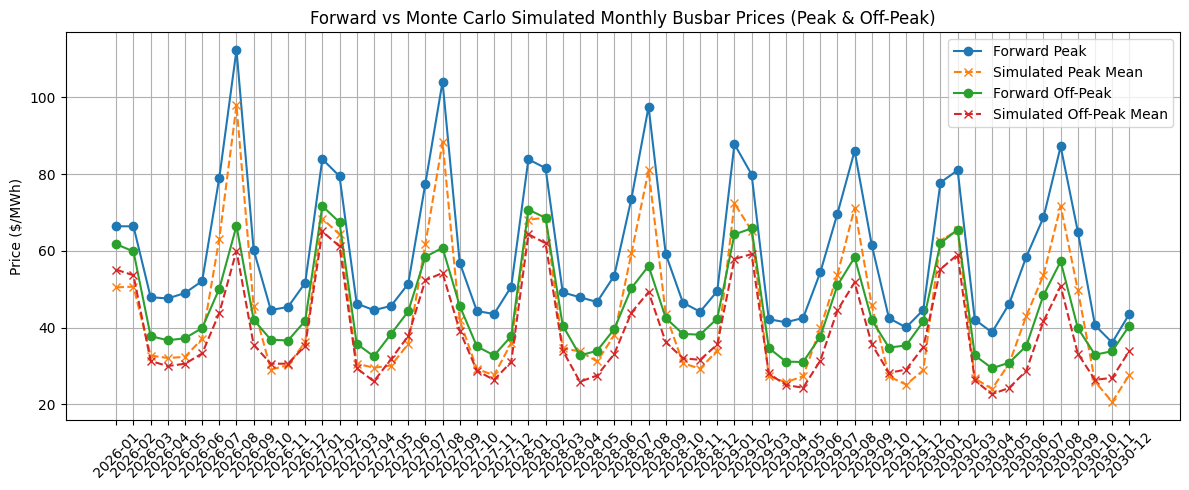

      Month  Forward_Peak  Sim_Peak_Mean  Forward_Off  Sim_Off_Mean
0   2026-01         66.41      50.470550        61.71     55.071275
1   2026-02         66.38      50.657122        59.84     53.624971
2   2026-03         47.90      32.702932        37.77     31.271026
3   2026-04         47.59      32.063767        36.67     29.962492
4   2026-05         49.00      32.347781        37.22     30.558581
5   2026-06         52.13      37.079492        39.89     33.236443
6   2026-07         79.10      63.190613        50.15     43.806462
7   2026-08        112.37      97.919659        66.49     60.018046
8   2026-09         60.22      45.489983        42.00     35.491649
9   2026-10         44.56      29.039774        36.83     30.563182
10  2026-11         45.37      30.182554        36.62     30.576620
11  2026-12         51.64      36.179196        41.75     35.237767
12  2027-01         83.90      68.391370        71.66     65.039263
13  2027-02         79.46      64.289231        

,Month,Forward_Peak,Sim_Peak_Mean,Sim_Peak_STD,Peak_VaR_75,Peak_CVaR_75,Forward_Off,Sim_Off_Mean,Sim_Off_STD,Off_VaR_75,Off_CVaR_75
0,2026-01,66.41,50.470550,57.571706,11.750369,<built-in method mean of numpy.ndarray object ...,61.71,55.071275,35.508578,31.269441,9.962904
1,2026-02,66.38,50.657122,57.105603,12.159660,<built-in method mean of numpy.ndarray object ...,59.84,53.624971,35.535910,29.493680,8.417941
2,2026-03,47.90,32.702932,57.130746,-6.043729,<built-in method mean of numpy.ndarray object ...,37.77,31.271026,35.270211,7.517661,-13.601256
3,2026-04,47.59,32.063767,57.368137,-6.838023,<built-in method mean of numpy.ndarray object ...,36.67,29.962492,35.268711,6.258663,-14.973277
4,2026-05,49.00,32.347781,57.170760,-6.064230,<built-in method mean of numpy.ndarray object ...,37.22,30.558581,35.307820,6.822938,-14.346231
5,2026-06,52.13,37.079492,57.034186,-1.173341,<built-in method mean of numpy.ndarray object ...,39.89,33.236443,35.458867,9.265252,-11.829962
6,2026-07,79.10,63.190613,57.628192,24.646680,<built-in method mean of numpy.ndarray object ...,50.15,43.806462,35.463709,19.968903,-1.325707
7,2026-08,112.37,97.919659,57.188355,59.022667,<built-in method mean of numpy.ndarray object ...,66.49,60.018046,35.378986,36.076673,15.236758
8,2026-09,60.22,45.489983,57.016735,6.989682,<built-in method mean of numpy.ndarray object ...,42.00,35.491649,35.351101,11.607950,-9.635772
9,2026-10,44.56,29.039774,56.908721,-9.096435,<built-in method mean of numpy.ndarray object ...,36.83,30.563182,35.177204,6.784081,-14.153350


In [8]:
data = pd.read_csv("../data/ERCOT-Historical-Data.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
fwd = pd.read_csv("../data/ERCOT-Forward-Prices.csv")
gen_pred = pd.read_csv("../data/ERCOT-Future-Predictions.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
fwd['Month'] = pd.to_datetime(fwd['Month'], format='%b-%y').dt.to_period('M').astype(str)
# gen_pred.head()
fwd.head()
montecarlo(data, fwd, gen_pred)

C:\Users\Anup\AppData\Local\Temp\ipykernel_35408\3605634075.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv("../data/MISO-Historical-Data.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
C:\Users\Anup\AppData\Local\Temp\ipykernel_35408\3605634075.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv("../data/MISO-Historical-Data.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
C:\Users\Anup\AppData\Local\Temp\ipykernel_35408\3605634075.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. 

Fitted historical stats:
Off-peak mu (hub,basis): [ 28.35840261 -10.66414489] samples: 13472
Off-peak cov:
 [[765.90348622 -15.24781976]
 [-15.24781976 338.66989206]]
Peak mu (hub,basis): [ 41.07171248 -13.92667583] samples: 12006
Peak cov:
 [[1673.73237661 -123.56962967]
 [-123.56962967  538.53370218]]


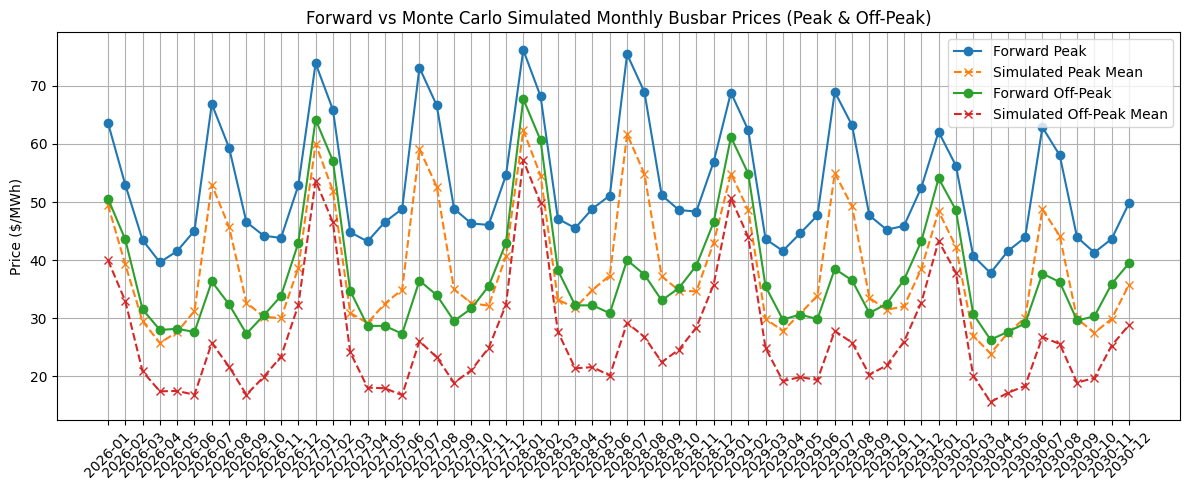

      Month  Forward_Peak  Sim_Peak_Mean  Forward_Off  Sim_Off_Mean
0   2026-01         63.65      49.512251        50.60     39.971788
1   2026-02         53.00      39.254513        43.55     32.944727
2   2026-03         43.45      29.451141        31.50     20.814809
3   2026-04         39.60      25.715073        27.95     17.369637
4   2026-05         41.55      27.589756        28.15     17.432699
5   2026-06         45.05      31.219605        27.60     16.790962
6   2026-07         66.90      52.999824        36.30     25.722789
7   2026-08         59.35      45.698345        32.35     21.612565
8   2026-09         46.55      32.666556        27.30     16.797878
9   2026-10         44.20      30.244607        30.45     19.849682
10  2026-11         43.80      29.969549        33.80     23.362997
11  2026-12         52.85      38.654060        42.95     32.216758
12  2027-01         73.90      60.010050        64.20     53.682466
13  2027-02         65.90      51.955401        

,Month,Forward_Peak,Sim_Peak_Mean,Sim_Peak_STD,Peak_VaR_75,Peak_CVaR_75,Forward_Off,Sim_Off_Mean,Sim_Off_STD,Off_VaR_75,Off_CVaR_75
0,2026-01,63.65,49.512251,44.511133,19.480347,<built-in method mean of numpy.ndarray object ...,50.60,39.971788,32.735309,18.078582,-1.622136
1,2026-02,53.00,39.254513,44.136111,9.438137,<built-in method mean of numpy.ndarray object ...,43.55,32.944727,32.859255,10.646015,-8.940126
2,2026-03,43.45,29.451141,44.110465,-0.528201,<built-in method mean of numpy.ndarray object ...,31.50,20.814809,32.784471,-1.067165,-20.936730
3,2026-04,39.60,25.715073,44.540699,-4.521812,<built-in method mean of numpy.ndarray object ...,27.95,17.369637,32.597528,-4.728633,-23.989795
4,2026-05,41.55,27.589756,44.414551,-2.535137,<built-in method mean of numpy.ndarray object ...,28.15,17.432699,32.792442,-4.377393,-24.341785
5,2026-06,45.05,31.219605,44.214433,1.612104,<built-in method mean of numpy.ndarray object ...,27.60,16.790962,32.652671,-5.097260,-24.615092
6,2026-07,66.90,52.999824,44.450452,23.267734,<built-in method mean of numpy.ndarray object ...,36.30,25.722789,32.809113,3.761137,-16.023638
7,2026-08,59.35,45.698345,44.454259,15.770241,<built-in method mean of numpy.ndarray object ...,32.35,21.612565,32.842427,-0.507148,-19.890494
8,2026-09,46.55,32.666556,44.266023,2.773025,<built-in method mean of numpy.ndarray object ...,27.30,16.797878,32.743261,-5.229636,-25.005452
9,2026-10,44.20,30.244607,44.179232,-0.131241,<built-in method mean of numpy.ndarray object ...,30.45,19.849682,32.827253,-2.310139,-21.861748


In [9]:
data = pd.read_csv("../data/MISO-Historical-Data.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
fwd = pd.read_csv("../data/MISO-Forward-Prices.csv")
gen_pred = pd.read_csv("../data/MISO-Future-Predictions.csv", parse_dates=['Date'], dayfirst=False, infer_datetime_format=True)
fwd['Month'] = pd.to_datetime(fwd['Month'], format='%b-%y').dt.to_period('M').astype(str)
# gen_pred.head()
fwd.head()
montecarlo(data, fwd, gen_pred)